In [2]:
#import modules
import numpy as np
from scipy.sparse import spdiags, csc_matrix
from ResSimUtils_ans import cal_kro_ans, cal_krw_ans, cal_Ta_ans
from matplotlib import pyplot as plt

<h2>結果の可視化＆保存用関数</h2>

In [3]:
# Pressure
def ShowResP_Cont(P, t, L, W, Pmin, Pmax, saveflag, showflag, fig):
    plt.imshow([P, P], extent = [0, L, 0, W], cmap = 'jet', vmin=Pmin, vmax=Pmax)
    plt.xlabel('L[m]')
    plt.ylabel('W[m]')
    plt.title("Reservoir Pressure [Pa]@ {:09.2f}days".format(t))
    plt.colorbar(aspect = 20, orientation= 'horizontal', shrink=1)
    if saveflag:
        plt.savefig('result_IMPES_ans/ResP/ResP_Cont{:09.2f}days.png'.format(t), facecolor="white")
    if showflag:
        plt.show()
        
    plt.clf()
    return

def ShowResP_Plot(x, P, t, L, Pmin, Pmax, saveflag, showflag, fig):
  # Function to Plot & Save Pressure
  # fig = plt.figure()
    plt.plot(x, P, label='{0:09.2f}[day]'.format(t)) 
    plt.xlabel('x[m]')
    plt.ylabel('Water Saturation [-]')
    plt.xlim(0, L)
    plt.ylim(Pmin, Pmax)
    plt.grid()
    plt.title('Reservoir Pressure@{0:09.2f}[day]'.format(t))
    if saveflag:
        plt.savefig('result_IMPES_ans/ResP/ResP_Plot{:09.2f}days.png'.format(t), facecolor="white")
    if showflag:
        plt.show()
    plt.clf()
    return

# Saturation
def ShowSw_Cont(Sw, t, L, W, saveflag, showflag, fig):
    plt.imshow([Sw, Sw], extent = [0, L, 0, W], cmap = 'jet', vmin=0, vmax=1)
    plt.xlabel('L[m]')
    plt.ylabel('W[m]')
    plt.title("Sw Profile@ {:09.2f}days".format(t))
    plt.colorbar(aspect = 20, orientation= 'horizontal', shrink=1)
    if saveflag:
        plt.savefig('result_IMPES_ans/SatWtr/Sw_Cont{:09.2f}days.png'.format(t), facecolor="white")
    if showflag:
        plt.show()
    plt.clf()
    return

def ShowSw_Plot(x, Sw, t, L, saveflag, showflag, fig):
  # Function to Plot & Save Pressure
  # fig = plt.figure()
    plt.plot(x, Sw, label='{0:09.2f}[day]'.format(t)) 
    plt.xlabel('x[m]')
    plt.ylabel('Water Saturation [-]')
    plt.xlim(0, L)
    plt.ylim(0, 1)
    plt.grid()
    plt.title('Sw Profile@ {0:09.2f}[day]'.format(t))
    if saveflag:
        plt.savefig('result_IMPES_ans/SatWtr/Sw_Plot{:09.2f}days.png'.format(t), facecolor="white")
    if showflag:
        plt.show()

    plt.clf()
    return

<h2>インプットパラメータ</h2>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

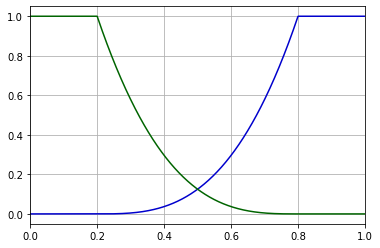

In [49]:
####### ----- Reservoir Properties and Simulation control ---- ######
# Simulation control Parameters
dt       = 0.050  # initial time step[day]. time step might be revised to meet CFL condition
t_max    = 365.25 # [day] simulation will continues until t becomes t_max
n_max    = 1e8 # maximum interation [-]
n_out    = 20 # 1000以上がいいと思う。
t_hist   = [0] # vector to hold time of day when simulation result is output
plotsave = 0 # boot variables to control save plot(1 == save)
plotshow = 1 # show Saturation distribution every t_out [day]
Pmin     = 990 # Pressure lower limit for plot
Pmax     = 1010 # Pressure lower limit for plot
saveResP_contour = 0    # save png 
showResP_contour = 0    # show contour

saveResP_plot    = 0    # save png 
showResP_plot    = 0    # show plot

saveSw_contour   = 0    # save png
showSw_contour   = 0    # show contour

saveSw_plot      = 0    # save png 
showSw_plot      = 0    # show plot

fig1             = plt.figure(); # figure for pressure contour
fig2             = plt.figure(); # figure for pressure plot
fig3             = plt.figure(); # figure for saturation contour
fig4             = plt.figure(); # figure for saturation plot


# Reservoir Properties
Lx = 1000 # Reservoir Length in x direction [ft]
Ly = 100 # Reservoir Length in y direction [ft]
h  = 10   # Reservoir tickness in z direction [ft]
nx = 31   # number of grid in x direction [-]
ny = 1   # number of grid in y direction [-]
dx = Lx / nx # grid size in x direction
dy = Ly / ny # grid size in y direction
perm_x  = 100*np.ones(nx) # Absolute permeability in x direction [mD]
# perm_y  = 100*np.ones(ny, nx) # Absolute permeability in y direction [mD]
phi_res = 0.3*np.ones(nx) # Porosity of reservoir [-]
P_init  = 1000*np.ones(nx) # Initial pressure in reservoir [PSI]

# define coordinate system
x    = np.zeros(nx)
x[0] = 0.5*dx
#y = np.np.zeros(ny)
#y[0] = 0.5*dy

# x coordinate
for i in range(1,len(x)):
    x[i] = x[i-1] + dx

###### ----- Fluid Properties ---- ######
# Injected water properties
vis_w        = 1.0 # viscosity of water [cp]
Bw           = 1.0 # formation volume factor of water
cw           = 1e-5 # compressibility of water [psi^-1]
Sw_i         = 0.2 # irreducible water saturation
Sw_init      = 0*np.ones(nx) # initial water saturation distribution
#Sw_init      = np.linspace(0, 1, nx)

perm_rw_max  = 1 # maximuam relative perm. of water [-]
nw           = 3.0 # exponent of water relative permeability curve [>1]

# Oil water Properties
vis_o        = 1.0 # viscosity of oil [cp]
Bo           = 1.0 # formation volume factor of oil
co           = 1e-5 # compressibility of oil [psi^-1]
So_r         = 0.2 # residual oil saturation
So_init      = 1 - Sw_init # initial oil saturation progile
perm_ro_max  = 1 # maximuam relative perm. of oil [-]
no           = 3.0 # exponent of oil relative permeability curve [>1]


###### ----- Well, Production & Injection Information ---- ######
# Injection Well Properties
# injection wells are controlled by flow rate[ft^3 /day]. Injecters are
# composed of water flow rate. Producers are only controlled by total flow
# rate.

# Injection wells (source term)
#Qin = np.zeros(ny, nx) # Injection wells
Qin = np.zeros(nx) # Injection wells
loc_Qin  = [16]
Qin[loc_Qin[0]]   = 2*426.5

# Production Well Properties
# production wells are controlled by flow rate[ft^s /day] or constant
# Bottom Hole Pressure, Pwf [PSI]. If Pwf is larger than Pi (mean pressure
# in CV), the situation is regarded as no production.

# Production wells (sink term) controlled by Flow Rate --------------------
#Qout = np.zeros(ny, nx) # Production wells
Qout = np.zeros(nx)
Qout_loc  = [0, 29]
Qout_name = ['P-1', 'P-2']
Qout[Qout_loc[0]]   = -426.5
Qout[Qout_loc[1]]   = -426.5

# Array to hold Production History
ProdOil   = np.zeros([len(Qout_loc)])
ProdWater = np.zeros([len(Qout_loc)])
t_hist    = []

###### ----- Show Relative Permeability Curve ---- ######
Sw_sample = np.linspace(0, 1, 1000);
krw_sample = cal_krw_ans(Sw_sample, Sw_i, So_r, perm_rw_max, nw)
kro_sample = cal_kro_ans(Sw_sample, Sw_i, So_r, perm_ro_max, no)

fig_RelPerm = plt.figure();
ax_rp  = fig_RelPerm.add_subplot(1,1,1)
ax_rp.plot(Sw_sample, krw_sample, color='#0000cd', label= 'Rel. Perm. Water')
ax_rp.plot(Sw_sample, kro_sample, color='#006400', label= 'Rel. Perm. Oil')
ax_rp.set_xlim(0, 1)
ax_rp.set_ylim(-0.05, 1.05)
ax_rp.grid()
plt.show()

<h2>計算部分</h2>

In [50]:
# Initialize Pressure and Saturation
p_old  = P_init
Sw_old = Sw_init

# time step
t = 0; n = 0;

# Initial Production
perm_rw = cal_krw_ans(Sw_old, Sw_i, So_r, perm_rw_max, nw)
perm_ro = cal_kro_ans(Sw_old, Sw_i, So_r, perm_ro_max, no)
# calculate fractional flow
lam_w = perm_rw / vis_w # mobility of water
lam_o = perm_ro / vis_o # mobility of oil

fw    = lam_w / (lam_w + lam_o) # fractional flow of water
fo    = lam_o / (lam_w + lam_o) # fractional flow of oil

# Production History
t_hist.append(t)
ProdWater[:] = -fw[Qout_loc] * Qout[Qout_loc]
ProdOil[:]   = -(Bw/Bo) * fo[Qout_loc] * Qout[Qout_loc]

# plot initial states
ShowResP_Cont(p_old, t, Lx, Ly, Pmin, Pmax, saveResP_contour, showResP_contour, fig1)
ShowResP_Plot(x, p_old, t, Lx, Pmin, Pmax, saveResP_plot, showResP_plot, fig2)
ShowSw_Cont(Sw_old, t, Lx, Ly, saveSw_contour, showSw_contour, fig3)
ShowSw_Plot(x, Sw_old, t, Lx, saveSw_plot, showSw_plot, fig4)


<Figure size 432x288 with 0 Axes>

In [51]:
print(ProdOil)
print(ProdWater)

[426.5 426.5]
[0. 0.]


In [52]:
# define matrix B and d
CV_vol = h*dx*dy
B      = spdiags(CV_vol*phi_res*cw/Bw, 0, nx, nx) # Volume accumlation for Pressure Eq.
D      = spdiags(Bw/(CV_vol*phi_res), 0, nx, nx) # d for Saturation Eq.

# start simulation
print('Start Simulation')
print('{0:06d} th iteration, {1:09.2f} days'.format(n, t))
while True:
    # compute Relative Permeability
    perm_rw = cal_krw_ans(Sw_old, Sw_i, So_r, perm_rw_max, nw)
    perm_ro = cal_kro_ans(Sw_old, Sw_i, So_r, perm_ro_max, no)
    
    # compute Transmissibility matrix
    T_water = cal_Ta_ans(perm_x,  perm_rw, h, dx, dy, vis_w, Bw, p_old, nx)
    T_oil   = cal_Ta_ans(perm_x,  perm_ro, h, dx, dy, vis_o, Bo, p_old, nx)
    
    # solve pressure Eq.
    P = np.linalg.solve((T_water + Bo/Bw*T_oil + (B.toarray()/dt)),\
                            (np.dot((B.toarray()/dt), p_old)+ Qin + Qout))
    
    # calculate fractional flow
    lam_w = perm_rw / vis_w # mobility of water
    lam_o = perm_ro / vis_o # mobility of oil
    
    fw    = lam_w / (lam_w + lam_o) # fractional flow of water
    fo    = lam_o / (lam_w + lam_o) # fractional flow of oil
    
    # solve water-saturation Eq.
    Sw_new = Sw_old + (D*dt)*(np.dot(-T_water.toarray(),P) + Qin + fw*Qout)
    
    # update time, pressure, saturation
    t += dt
    n += 1
    p_old  = P
    Sw_old = Sw_new
    
    # output result
    if n % n_out == 0:
        print('{0:06d} th iteration, {1:09.2f} days'.format(n, t))
        # Pressure and Saturation Profile
        ShowResP_Cont(p_old, t, Lx, Ly, Pmin, Pmax, saveResP_contour, showResP_contour, fig1)
        ShowResP_Plot(x, p_old, t, Lx, Pmin, Pmax, saveResP_plot, showResP_plot, fig2)
        ShowSw_Cont(Sw_old, t, Lx, Ly, saveSw_contour, showSw_contour, fig3)
        ShowSw_Plot(x, Sw_old, t, Lx, saveSw_plot, showSw_plot, fig4)
        
        # Production History
        t_hist.append(t)
        # ProdWater = np.hstack((ProdWater, -fw[Qout_loc] * Qout[Qout_loc]))
        ProdWater = np.concatenate([ProdWater, -fw[Qout_loc] * Qout[Qout_loc]], 0)
        # ProdOil   = np.hstack((ProdOil,   -(Bw/Bo) * fo[Qout_loc] * Qout[Qout_loc])) 
        ProdOil   = np.concatenate([ProdOil,   -(Bw/Bo) * fo[Qout_loc] * Qout[Qout_loc]], 0)
    
    
    # exit infinite loop
    if t >= t_max or n >= n_max:
        break
print('End Simulation')

Start Simulation
000000 th iteration, 000000.00 days
000020 th iteration, 000001.00 days
000040 th iteration, 000002.00 days
000060 th iteration, 000003.00 days
000080 th iteration, 000004.00 days
000100 th iteration, 000005.00 days
000120 th iteration, 000006.00 days
000140 th iteration, 000007.00 days
000160 th iteration, 000008.00 days
000180 th iteration, 000009.00 days
000200 th iteration, 000010.00 days
000220 th iteration, 000011.00 days
000240 th iteration, 000012.00 days
000260 th iteration, 000013.00 days
000280 th iteration, 000014.00 days
000300 th iteration, 000015.00 days
000320 th iteration, 000016.00 days
000340 th iteration, 000017.00 days
000360 th iteration, 000018.00 days
000380 th iteration, 000019.00 days
000400 th iteration, 000020.00 days
000420 th iteration, 000021.00 days
000440 th iteration, 000022.00 days
000460 th iteration, 000023.00 days
000480 th iteration, 000024.00 days
000500 th iteration, 000025.00 days
000520 th iteration, 000026.00 days
000540 th i

<Figure size 432x288 with 0 Axes>

<h2>生産履歴</h2>

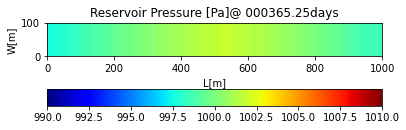

<Figure size 432x288 with 0 Axes>

In [56]:
ShowResP_Cont(p_old, t, Lx, Ly, Pmin, Pmax, saveResP_contour, 1, fig1)

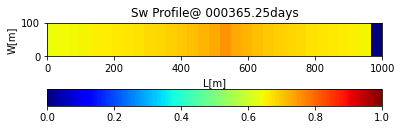

<Figure size 432x288 with 0 Axes>

In [57]:
ShowSw_Cont(Sw_old, t, Lx, Ly, saveSw_contour, 1, fig3)

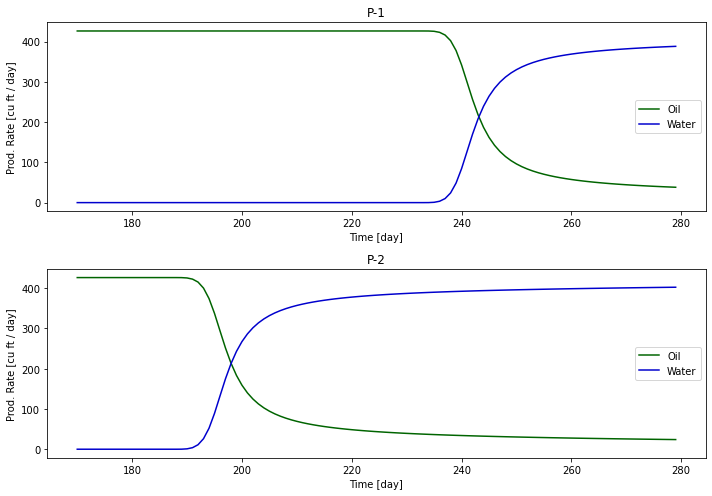

In [59]:
Oil = ProdOil.reshape(-1, len(Qout_loc))
Water = ProdWater.reshape(-1, len(Qout_loc))

fig_prod, ax = plt.subplots(len(Qout_loc), 1, tight_layout=True, figsize= (10, 7))

# default
ind_str = 0
ind_end = len(t_hist)

ind_str = 170
ind_end = 280

for i in range(0, len(Qout_loc)):
    ax[i].plot(t_hist[ind_str : ind_end], Oil[ind_str : ind_end,i], color='#006400', label= 'Oil')
    ax[i].plot(t_hist[ind_str : ind_end], Water[ind_str : ind_end,i], color='#0000cd', label= 'Water')
    ax[i].set_xlabel('Time [day]')
    ax[i].set_ylabel('Prod. Rate [cu ft / day]')
    ax[i].set_title(Qout_name[i])
    ax[i].legend()
plt.subplots_adjust(wspace=0.4, hspace=0.6)